# Classification de documents : prise en main des outils

Le but de ce TP est de classer des documents textuels... Dans un premier temps, nous allons vérifier le bon fonctionnement des outils sur des données jouets puis appliquer les concepts sur des données réelles.


## Conception de la chaine de traitement
Pour rappel, une chaine de traitement de documents classique est composée des étapes suivantes:
1. Lecture des données et importation
    - Dans le cadre de nos TP, nous faisons l'hypothèse que le corpus tient en mémoire... Si ce n'est pas le cas, il faut alors ajouter des structures de données avec des buffers (*data-reader*), bien plus complexes à mettre en place.
    - Le plus grand piège concerne l'encodage des données. Dans le TP... Pas (ou peu) de problème. Dans la vraie vie: il faut faire attention à toujours maitriser les formats d'entrée et de sortie.
1. Traitement des données brutes paramétrique. Chaque traitement doit être activable ou desactivable + paramétrable si besoin.
    - Enlever les informations *inutiles* : chiffre, ponctuations, majuscules, etc... <BR>
    **L'utilité dépend de l'application!**
    - Segmenter en mots (=*Tokenization*)
    - Elimination des stop-words
    - Stemming/lemmatisation (racinisation)
    - Byte-pair encoding pour trouver les mots composés (e.g. Sorbonne Université, Ville de Paris, Premier Ministre, etc...)
1. Traitement des données numériques
    - Normalisation *term-frequency* / binarisation
    - Normalisation *inverse document frequency*
    - Elimination des mots rares, des mots trop fréquents
    - Construction de critère de séparabilité pour éliminer des mots etc...
1. Apprentissage d'un classifieur
    - Choix du type de classifieur
    - Réglage des paramètres du classifieur (régularisation, etc...)

## Exploitation de la chaine de traitement

On appelle cette étape la réalisation d'une campagne d'expériences: c'est le point clé que nous voulons traviller en TAL cette année.
1. Il est impossible de tester toutes les combinaisons par rapport aux propositions ci-dessus... Il faut donc en éliminer un certain nombre.
    - En discutant avec les experts métiers
    - En faisant des tests préliminaires
1. Après ce premier filtrage, il faut:
    - Choisir une évaluation fiable et pas trop lente (validation croisée, leave-one-out, split apprentissage/test simple)
    - Lancer des expériences en grand
        - = *grid-search*
        - parallèliser sur plusieurs machines
        - savoir lancer sur un serveur et se déconnecter
1. Collecter et analyser les résultats


## Inférence

L'inférence est ensuite très classique: la chaine de traitement optimale est apte à traiter de nouveaux documents

# Charger les données

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import codecs
import re
import os.path
import nltk
from nltk.stem import PorterStemmer
import string
import time

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV, cross_val_score

In [23]:
# Chargement des données:
def load_pres(fname):
    alltxts = []
    alllabs = []
    s=codecs.open(fname, 'r','utf-8') # pour régler le codage
    while True:
        txt = s.readline()
        if(len(txt))<5:
            break
        lab = re.sub(r"<[0-9]*:[0-9]*:(.)>.*","\\1",txt)
        txt = re.sub(r"<[0-9]*:[0-9]*:.>(.*)","\\1",txt)
        if lab.count('M') >0:
            alllabs.append(-1)
        else: 
            alllabs.append(1)
        alltxts.append(txt)
    return alltxts,alllabs


In [24]:
fname_train = "/Users/louisedry/Downloads/tuto_TAL-main/notebooks/ressources/AFDpresidentutf8/corpus.tache1.learn.utf8"
fname_test ="/Users/louisedry/Downloads/tuto_TAL-main/notebooks/ressources/AFDpresidentutf8/corpus.tache1.test.utf8"

X_train,y_train = load_pres(fname_train)
X_test,y_test = load_pres(fname_test)

In [25]:
classes_train = [pol for pol in y_train]
text_train = [text for text in X_train]

In [26]:
classes_test = [pol for pol in y_test]
text_test = [text for text in X_test]

In [27]:
print(len(X_train),len(y_train))
print(X_train[0])
print(y_train[0])
print(X_train[-1])
print(y_train[-1])

57413 57413
 Quand je dis chers amis, il ne s'agit pas là d'une formule diplomatique, mais de l'expression de ce que je ressens.

1
 Je compte sur vous.

1


In [28]:
print(sum(np.array(y_train)==1)/len(y_train))
print(sum(np.array(y_train)!=1)/len(y_train))

0.8689669587027329
0.13103304129726717


In [29]:
print(sum(np.array(y_test)==1)/len(y_test))
print(sum(np.array(y_test)!=1)/len(y_test))

0.8925705029084751
0.10742949709152493


# Transformation paramétrique du texte

Vous devez tester, par exemple, les cas suivants:
- transformation en minuscule ou pas
- suppression de la ponctuation
- transformation des mots entièrement en majuscule en marqueurs spécifiques
- suppression des chiffres ou pas
- conservation d'une partie du texte seulement (seulement la première ligne = titre, seulement la dernière ligne = résumé, ...)
- stemming
- ...


Vérifier systématiquement sur un exemple ou deux le bon fonctionnement des méthodes sur deux documents (au moins un de chaque classe).

[('de', 68579), ('', 57413), ('la', 39694), ('et', 34709), ('à', 26075), ('les', 24312), ('le', 24256), ('des', 21492), ('que', 15737), ('qui', 14808), ('en', 14197), ('pour', 11012), ('dans', 10957), ('du', 10638), ('un', 9237), ('une', 8900), ('nous', 7089), ('plus', 7078), ('au', 7067), ('est', 6981), ('vous', 6974), ('ce', 6439), ('a', 6303), ('je', 6014), ('pas', 5797), ('par', 5500), ('notre', 5214), ('ne', 5156), ('sur', 5111), ('nos', 4718)]


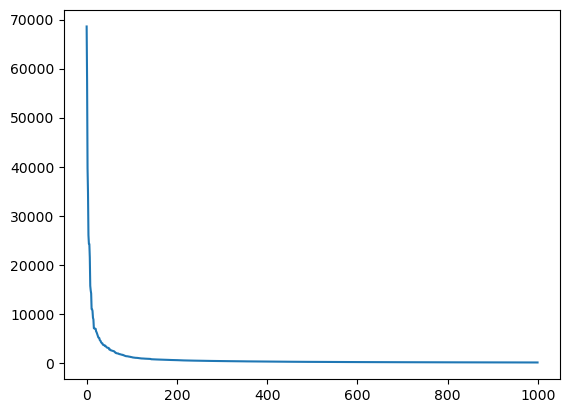

In [30]:
from collections import Counter

wc = Counter()
for text in X_train:
    wc.update(text.split(" "))
    
freq = [f for w,f in wc.most_common(1000)]
plt.plot(freq[:1000])
print(wc.most_common(30))

In [31]:
test1 = X_train[0] # 1
test2 = X_train[390] # -1

In [32]:
import string

punc = string.punctuation  
punc += '\n\r\t'
test1_punc = test1.translate(str.maketrans(punc, ' ' * len(punc)))  
print(test1_punc)

test2_punc = test2.translate(str.maketrans(punc, ' ' * len(punc)))  
print(test2_punc)

 Quand je dis chers amis  il ne s agit pas là d une formule diplomatique  mais de l expression de ce que je ressens  
 On ne passe donc pas d une période paisible et sûre à une période d incertitude  


In [33]:
import unicodedata

test1_low = unicodedata.normalize('NFD', test1).encode('ascii', 'ignore').decode("utf-8")
test1_low = test1_low.lower()
print(test1_low )


test2_low = unicodedata.normalize('NFD', test2).encode('ascii', 'ignore').decode("utf-8")
test2_low = test2_low.lower()
print(test2_low )

 quand je dis chers amis, il ne s'agit pas la d'une formule diplomatique, mais de l'expression de ce que je ressens.

 on ne passe donc pas d'une periode paisible et sure a une periode d'incertitude.



In [34]:
test1_both = test1_low.translate(str.maketrans(punc, ' ' * len(punc)))  
test2_both = test2_low.translate(str.maketrans(punc, ' ' * len(punc)))  
print(test1_both)
print(test2_both)

 quand je dis chers amis  il ne s agit pas la d une formule diplomatique  mais de l expression de ce que je ressens  
 on ne passe donc pas d une periode paisible et sure a une periode d incertitude  


Combinaison dans une fonction de preprocessing

# Extraction du vocabulaire

Exploration préliminaire des jeux de données.

- Quelle est la taille d'origine du vocabulaire?
- Que reste-t-il si on ne garde que les 100 mots les plus fréquents? [word cloud]
- Quels sont les 100 mots dont la fréquence documentaire est la plus grande? [word cloud]
- Quels sont les 100 mots les plus discriminants au sens de odds ratio? [word cloud]
- Quelle est la distribution d'apparition des mots (Zipf)
- Quels sont les 100 bigrammes/trigrammes les plus fréquents?

In [35]:
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer()
Xcount_train = count.fit_transform(X_train)
print("Il y a " + str(len(count.get_feature_names())) + " mots dans l'ensemble de training.")
Xcount_test = count.fit_transform(X_test)
print("Il y a " + str(len(count.get_feature_names())) + " mots dans l'ensemble de test.")

/Users/louisedry/mambaforge/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Il y a 28524 mots dans l'ensemble de training.
Il y a 21539 mots dans l'ensemble de test.


In [36]:
wc = Counter()
for text in X_train:
    wc.update(text.split(" "))

# 100 mots les plus fréquents du train
freq_train_all = [f for w,f in wc.most_common()]
freq_train = freq_train_all[:100]
words_train_all = [w for w,f in wc.most_common()]
words_train = words_train_all[:100]

(-0.5, 399.5, 199.5, -0.5)

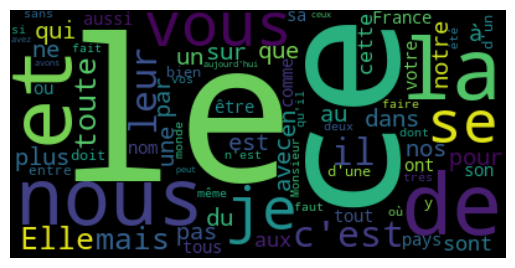

In [37]:
from wordcloud import WordCloud

words_train = " ".join(words_train)
wordcloud = WordCloud().generate(words_train)

import matplotlib.pyplot as plt
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

In [38]:
for text in X_test:
    wc.update(text.split(" "))

# 100 mots les plus fréquents du train
freq_test_all = [f for w,f in wc.most_common()]
freq_test = freq_test_all[:100]
words_test_all = [w for w,f in wc.most_common()]
words_test = words_test_all[:100]

(-0.5, 399.5, 199.5, -0.5)

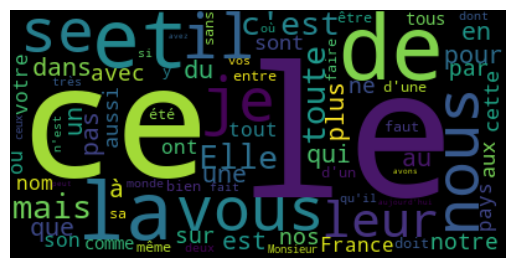

In [39]:
words_test = " ".join(words_test)
wordcloud = WordCloud().generate(words_test)

import matplotlib.pyplot as plt
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

In [40]:
import operator

frequency_train = {}
frequency_test = {} 

for i in range(len(words_train_all)) :
    frequency_train[words_train_all[i]] = freq_train_all[i]

for i in range(len(words_test_all)) :
    frequency_test[words_test_all[i]] = freq_test_all[i]

rank = 1
column_header = ['Rank', 'Frequency', 'Frequency * Rank']

df_train = pd.DataFrame(columns = column_header)
collection_train = sorted(frequency_train.items(), key=operator.itemgetter(1), reverse = True)

df_test = pd.DataFrame(columns = column_header)
collection_test = sorted(frequency_test.items(), key=operator.itemgetter(1), reverse = True)

for word, freq in collection_train:
    df_train.loc[word] = [rank, freq, rank*freq]
    rank = rank + 1

for word, freq in collection_test:
    df_test.loc[word] = [rank, freq, rank*freq]
    rank = rank + 1

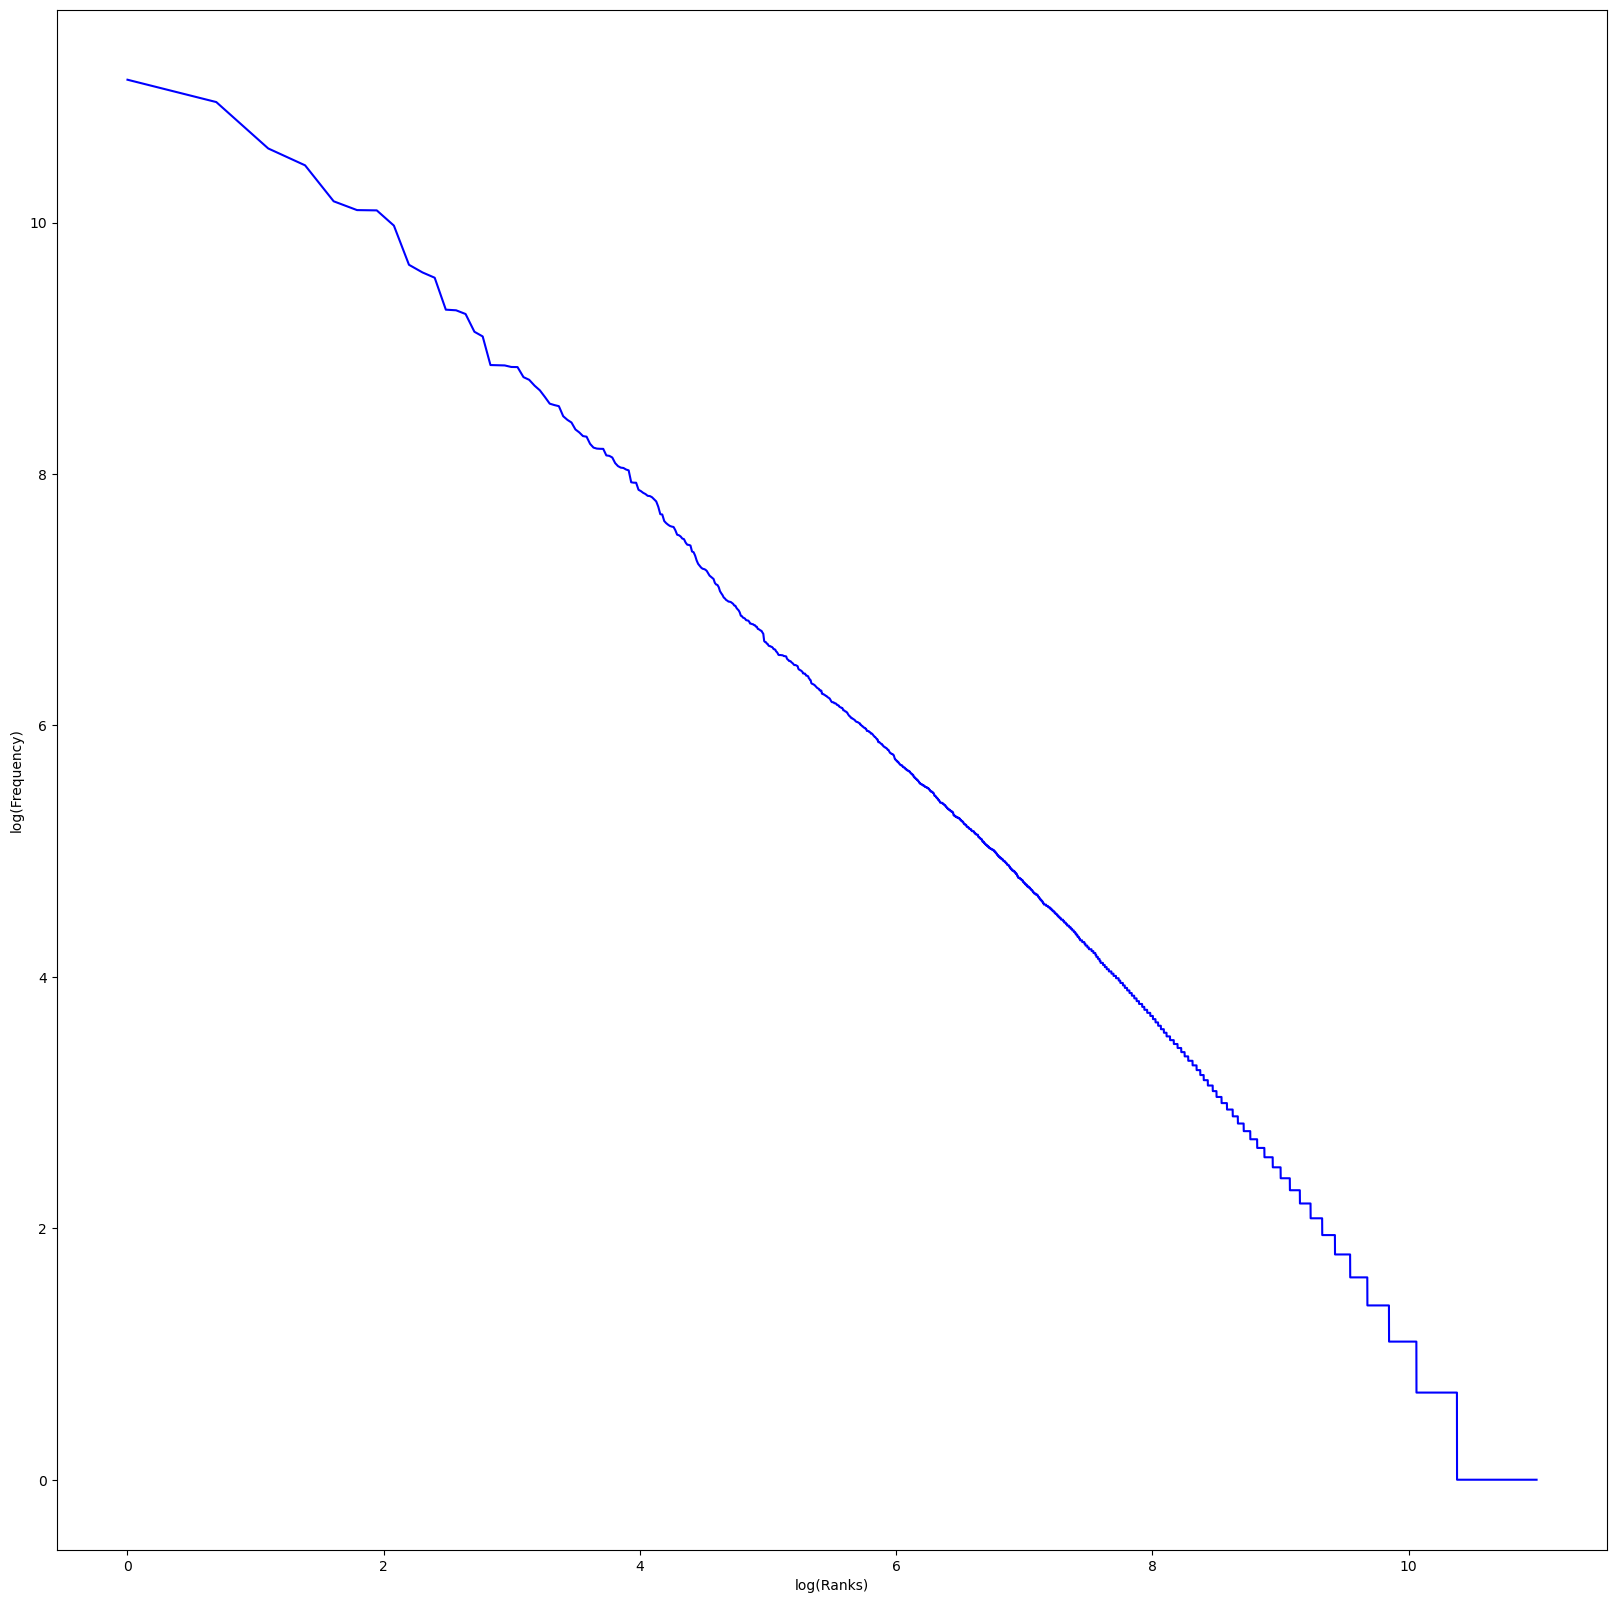

In [41]:
plt.figure(figsize=(20,20))  #to increase the plot resolution
plt.ylabel("log(Frequency)")
plt.xlabel("log(Ranks)")
plt.plot(np.log(df_train.loc[:,'Rank']),np.log(df_train.loc[:,'Frequency']), 'b')
#plt.plot(np.log(df_test.loc[:,'Rank']),np.log(df_test.loc[:,'Frequency']), 'r')

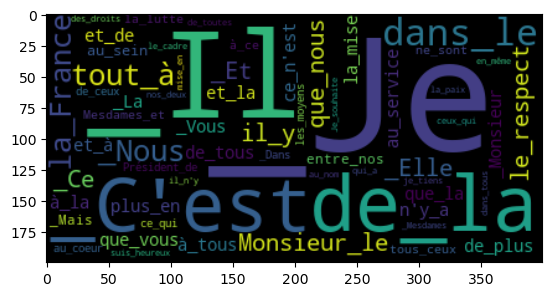

In [42]:
twograms_c = Counter()
for test in X_train:
  x = test.rstrip().split(" ")
  twograms_c.update(set(zip(x[:-2],x[1:-1],x[2:])))

# 100 bigrammes les plus fréquents du train
freq = [f for w,f in twograms_c.most_common()]
freq = freq[:100]
twograms = [w for w,f in twograms_c.most_common()]
twograms = twograms[:100]

new_twograms = []
for words in twograms:
  new_twograms.append(words[0]+'_'+words[1])

words = ' '.join([str(elem) for elem in new_twograms])
wordcloud = WordCloud().generate(words)

import matplotlib.pyplot as plt
plt.imshow(wordcloud, interpolation='bilinear')


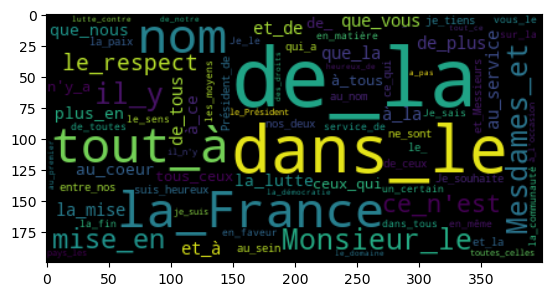

In [43]:
twograms_c = Counter()
for test in X_test:
  x = test.rstrip().split(" ")
  twograms_c.update(set(zip(x[:-2],x[1:-1],x[2:])))

# 100 bigrammes les plus fréquents du train
freq = [f for w,f in twograms_c.most_common()]
freq = freq[:100]
twograms = [w for w,f in twograms_c.most_common()]
twograms = twograms[:100]

new_twograms = []
for words in twograms:
  new_twograms.append(words[0]+'_'+words[1])

words = ' '.join([str(elem) for elem in new_twograms])
wordcloud = WordCloud().generate(words)

import matplotlib.pyplot as plt
plt.imshow(wordcloud, interpolation='bilinear')

## Equilibrage des données

Un problème reconnu comme dur dans la communauté est celui de l'équilibrage des classes (*balance* en anglais). Que faire si les données sont à 80, 90 ou 99% dans une des classes?
Le problème est dur mais fréquent; les solutions sont multiples mais on peut isoler 3 grandes familles de solution.

1. Ré-équilibrer le jeu de données: supprimer des données dans la classe majoritaire et/ou sur-échantilloner la classe minoritaire.<BR>
   $\Rightarrow$ A vous de jouer pour cette technique
1. Changer la formulation de la fonction de coût pour pénaliser plus les erreurs dans la classe minoritaire:
soit une fonction $\Delta$ mesurant les écarts entre $f(x_i)$ et $y_i$ 
$$C = \sum_i  \alpha_i \Delta(f(x_i),y_i), \qquad \alpha_i = \left\{
\begin{array}{ll}
1 & \text{si } y_i \in \text{classe majoritaire}\\
B>1 & \text{si } y_i \in \text{classe minoritaire}\\
\end{array} \right.$$
<BR>
   $\Rightarrow$ Les SVM et d'autres approches sklearn possèdent des arguments pour régler $B$ ou $1/B$... Ces arguments sont utiles mais pas toujours suffisant.
1. Courbe ROC et modification du biais. Une fois la fonction $\hat y = f(x)$ apprise, il est possible de la *bidouiller* a posteriori: si toutes les prédictions $\hat y$ sont dans une classe, on va introduire $b$ dans $\hat y = f(x) + b$ et le faire varier jusqu'à ce qu'un des points change de classe. On peut ensuite aller de plus en plus loin.
Le calcul de l'ensemble des scores associés à cette approche mène directement à la courbe ROC.

**Note:** certains classifieurs sont intrinsèquement plus résistante au problème d'équilibrage, c'est par exemple le cas des techniques de gradient boosting que vous verrez l'an prochain.

In [44]:
idx_train_1 = np.where((np.array(y_train)!=1)==True)

In [45]:
y_train_1 = y_train.copy()
X_train_1 = X_train.copy()

for i in sorted(idx_train_1[0], reverse=True):
    del y_train_1[i]
    del X_train_1[i]

In [46]:
idx_train_m1 = np.where((np.array(y_train)==1)==True)

In [47]:
y_train_m1 = y_train.copy()
X_train_m1 = X_train.copy()

for i in sorted(idx_train_m1[0], reverse=True):
    del y_train_m1[i]
    del X_train_m1[i]

In [48]:
import random as rd

X_new_train_1 = X_train_1.copy()
y_new_train_1 = y_train_1.copy()

list_index = [k for k in range(len(X_train_1))]
for i in sorted(rd.sample(list_index,int(len(X_train_1)/2)), reverse=True):
    del X_new_train_1[i]
    del y_new_train_1[i]

print(len(X_new_train_1))

24945


In [49]:
X_new_train_m1 = X_train_m1*3
y_new_train_m1 = y_train_m1*3

In [50]:
X_new_train = X_new_train_1 + X_new_train_m1
y_new_train = y_new_train_1 + y_new_train_m1

In [51]:
print(len(X_new_train))
print(len(y_new_train))

47514
47514


In [52]:
print(sum(np.array(y_new_train)==1)/len(y_new_train))
print(sum(np.array(y_new_train)!=1)/len(y_new_train))

0.5250031569642631
0.47499684303573686


Maintenant on construit 2 ensembles de données dont un premier scindé en 2:
- la partie fit, inclue dans la partie training, qui sert à fit un modèle
- la partie boost, inclue dans la partie training, qui permet de booster les hyperparamètres du modèle et du preprocesseur sur des données encore inconnues
- la partie test qui sert à tester le modèle boosté sur des données nouvelles pour voir les vraies performances du modèle

In [53]:
from sklearn.model_selection import train_test_split

X_fit, X_boost, y_fit, y_boost = train_test_split(X_new_train, y_new_train, test_size = 0.33, random_state = 42)
print(len(X_fit))
print(len(y_fit))
print(len(X_boost))
print(len(y_boost))

31834
31834
15680
15680


In [54]:
classes_fit = [pol for pol in y_fit]
corpus_fit = [text for text in X_fit]
classes_boost = [pol for pol in y_boost]
corpus_boost = [text for text in X_boost]

# Modèles de Machine Learning

Avant de lancer de grandes expériences, il faut se construire une base de travail solide en étudiant les questions suivantes:

- Combien de temps ça prend d'apprendre un classifieur NB/SVM/RegLog sur ces données en fonction de la taille du vocabulaire?
- La validation croisée est-elle nécessaire? Est ce qu'on obtient les mêmes résultats avec un simple *split*?
- La validation croisée est-elle stable? A partir de combien de fold (travailler avec différentes graines aléatoires et faire des statistiques basiques)?

In [55]:
results_fit = pd.DataFrame(columns=['NB', 'Temps_NB', 'LR', 'Temps_LR', 'SVM', 'Temps_SVM'], index=['ø', 'lower+punc', 'ngram=(1,1)', 'ngram=(1,2)', 'ngram=(1,3)', 'strip_accents', 'stopwords', 'max_features', 'max_def', 'boost'])
results_cv = pd.DataFrame(columns=['NB', 'Temps_NB', 'LR', 'Temps_LR', 'SVM', 'Temps_SVM'], index=['ø', 'lower+punc', 'ngram=(1,1)', 'ngram=(1,2)', 'ngram=(1,3)', 'strip_accents', 'stopwords', 'max_features', 'max_def', 'boost'])

Aucun prétraitement

In [56]:
vectorizer_none = CountVectorizer()

X_train_none = vectorizer_none.fit_transform(corpus_fit) 
X_test_none = vectorizer_none.transform(corpus_boost)

#Naïve Bayes
start_nb = time.time()
nb_clf = MultinomialNB()
nb_clf.fit(X_train_none, classes_fit)
end_nb = time.time()
results_fit.loc['ø', 'NB'] = nb_clf.score(X_test_none, classes_boost)
results_fit.loc['ø', 'Temps_NB'] = end_nb - start_nb

#Logistic Regression
start_lr = time.time()
lr_clf = LogisticRegression(random_state=0, C=1e-3)
lr_clf.fit(X_train_none, classes_fit)
end_lr = time.time()
results_fit.loc['ø', 'LR'] = lr_clf.score(X_test_none, classes_boost)
results_fit.loc['ø', 'Temps_LR'] = end_lr - start_lr

#Linear SVM
start_svm = time.time()
svm_clf = LinearSVC(random_state=0, tol=1e-5, C=1e-3)
svm_clf.fit(X_train_none, classes_fit)
end_svm = time.time()
svm_clf.score(X_test_none, classes_boost)
results_fit.loc['ø', 'SVM'] = svm_clf.score(X_test_none, classes_boost)
results_fit.loc['ø', 'Temps_SVM'] = end_svm - start_svm

In [57]:
X = vectorizer_none.fit_transform(X_new_train)

#Naïve Bayes
start_nb = time.time()
cv_nb_none = cross_val_score(nb_clf, X, y_new_train, cv=5, scoring='accuracy')
end_nb = time.time()
results_cv.loc['ø', 'NB'] = cv_nb_none.mean()
results_cv.loc['ø', 'Temps_NB'] = end_nb - start_nb

#Logistic Regression
start_lr = time.time()
cv_lr_none = cross_val_score(lr_clf, X, y_new_train, cv=5, scoring='accuracy')
end_lr = time.time()
results_cv.loc['ø', 'LR'] = cv_lr_none.mean()
results_cv.loc['ø', 'Temps_LR'] = end_lr - start_lr

#Linear SVM
start_svm = time.time()
cv_svm_none = cross_val_score(svm_clf, X, y_new_train, cv=5, scoring='accuracy')
end_svm = time.time()
results_cv.loc['ø', 'SVM'] = cv_svm_none.mean()
results_cv.loc['ø', 'Temps_SVM'] = end_svm - start_svm

Passage en minscule + retrait de la ponctuation

In [58]:
def preprocess(text):
    ## removing punctuation
    punc = string.punctuation  
    punc += '\n'
    text = text.translate(str.maketrans(punc, ' ' * len(punc)))  

    ## putting text to lower case
    text = text.lower()

    return(text)

In [59]:
vectorizer_low_punc = CountVectorizer(preprocessor=preprocess)

X_train_lp = vectorizer_none.fit_transform(corpus_fit) 
X_test_lp = vectorizer_none.transform(corpus_boost)

#Naïve Bayes
start_nb = time.time()
nb_clf = MultinomialNB()
nb_clf.fit(X_train_lp, classes_fit)
end_nb = time.time()
results_fit.loc['lower+punc', 'NB'] = nb_clf.score(X_test_lp, classes_boost)
results_fit.loc['lower+punc', 'Temps_NB'] = end_nb - start_nb

#Logistic Regression
start_lr = time.time()
lr_clf = LogisticRegression(random_state=0, C=1e-3)
lr_clf.fit(X_train_lp, classes_fit)
end_lr = time.time()
results_fit.loc['lower+punc', 'LR'] = lr_clf.score(X_test_lp, classes_boost)
results_fit.loc['lower+punc', 'Temps_LR'] = end_lr - start_lr

#Linear SVM
start_svm = time.time()
svm_clf = LinearSVC(random_state=0, tol=1e-5, C=1e-3)
svm_clf.fit(X_train_lp, classes_fit)
end_svm = time.time()
results_fit.loc['lower+punc', 'SVM'] = svm_clf.score(X_test_lp, classes_boost)
results_fit.loc['lower+punc', 'Temps_SVM'] = end_svm - start_svm

In [60]:
X = vectorizer_low_punc.fit_transform(X_new_train)

#Naïve Bayes
start_nb = time.time()
cv_nb_lp = cross_val_score(nb_clf, X, y_new_train, cv=5, scoring='accuracy')
end_nb = time.time()
results_cv.loc['lower+punc', 'NB'] = cv_nb_lp.mean()
results_cv.loc['lower+punc', 'Temps_NB'] = end_nb - start_nb

#Logistic Regression
start_lr = time.time()
cv_lr_lp = cross_val_score(lr_clf, X, y_new_train, cv=5, scoring='accuracy')
end_lr = time.time()
results_cv.loc['lower+punc', 'LR'] = cv_lr_lp.mean()
results_cv.loc['lower+punc', 'Temps_LR'] = end_lr - start_lr

#Linear SVM
start_svm = time.time()
cv_svm_lp = cross_val_score(svm_clf, X, y_new_train, cv=5, scoring='accuracy')
end_svm = time.time()
results_cv.loc['lower+punc', 'SVM'] = cv_svm_lp.mean()
results_cv.loc['lower+punc', 'Temps_SVM'] = end_svm - start_svm

ngram variant entre 1, 2 et 3

In [61]:
vectorizer_ngram1 = CountVectorizer(ngram_range=(1,1), preprocessor=preprocess)

X_train_ngram1 = vectorizer_ngram1.fit_transform(corpus_fit) 
X_test_ngram1 = vectorizer_ngram1.transform(corpus_boost)

#Naïve Bayes
start_nb = time.time()
nb_clf = MultinomialNB()
nb_clf.fit(X_train_ngram1, classes_fit)
end_nb = time.time()
results_fit.loc['ngram=(1,1)', 'NB'] = nb_clf.score(X_test_ngram1, classes_boost)
results_fit.loc['ngram=(1,1)', 'Temps_NB'] = end_nb - start_nb

#Logistic Regression
start_lr = time.time()
lr_clf = LogisticRegression(random_state=0, C=1e-3)
lr_clf.fit(X_train_ngram1, classes_fit)
end_lr = time.time()
results_fit.loc['ngram=(1,1)', 'LR'] = lr_clf.score(X_test_ngram1, classes_boost)
results_fit.loc['ngram=(1,1)', 'Temps_LR'] = end_lr - start_lr

#Linear SVM
start_svm = time.time()
svm_clf = LinearSVC(random_state=0, tol=1e-5, C=1e-3)
svm_clf.fit(X_train_ngram1, classes_fit)
end_svm = time.time()
results_fit.loc['ngram=(1,1)', 'SVM'] = svm_clf.score(X_test_ngram1, classes_boost)
results_fit.loc['ngram=(1,1)', 'Temps_SVM'] = end_svm - start_svm

In [62]:
X = vectorizer_ngram1.fit_transform(X_new_train)

#Naïve Bayes
start_nb = time.time()
cv_nb_ngram1 = cross_val_score(nb_clf, X, y_new_train, cv=5, scoring='accuracy')
end_nb = time.time()
results_cv.loc['ngram=(1,1)', 'NB'] = cv_nb_ngram1.mean()
results_cv.loc['ngram=(1,1)', 'Temps_NB'] = end_nb - start_nb

#Logistic Regression
start_lr = time.time()
cv_lr_ngram1 = cross_val_score(lr_clf, X, y_new_train, cv=5, scoring='accuracy')
end_lr = time.time()
results_cv.loc['ngram=(1,1)', 'LR'] = cv_lr_ngram1.mean()
results_cv.loc['ngram=(1,1)', 'Temps_LR'] = end_lr - start_lr

#Linear SVM
start_svm = time.time()
cv_svm_ngram1 = cross_val_score(svm_clf, X, y_new_train, cv=5, scoring='accuracy')
end_svm = time.time()
results_cv.loc['ngram=(1,1)', 'SVM'] = cv_svm_ngram1.mean()
results_cv.loc['ngram=(1,1)', 'Temps_SVM'] = end_svm - start_svm

In [63]:
vectorizer_ngram2 = CountVectorizer(ngram_range=(1,2), preprocessor=preprocess)

X_train_ngram2 = vectorizer_ngram2.fit_transform(corpus_fit) 
X_test_ngram2 = vectorizer_ngram2.transform(corpus_boost)

#Naïve Bayes
start_nb = time.time()
nb_clf = MultinomialNB()
nb_clf.fit(X_train_ngram2, classes_fit)
end_nb = time.time()
results_fit.loc['ngram=(1,2)', 'NB'] = nb_clf.score(X_test_ngram2, classes_boost)
results_fit.loc['ngram=(1,2)', 'Temps_NB'] = end_nb - start_nb

#Logistic Regression
start_lr = time.time()
lr_clf = LogisticRegression(random_state=0, C=1e-3)
lr_clf.fit(X_train_ngram2, classes_fit)
end_lr = time.time()
results_fit.loc['ngram=(1,2)', 'LR'] = lr_clf.score(X_test_ngram2, classes_boost)
results_fit.loc['ngram=(1,2)', 'Temps_LR'] = end_lr - start_lr

#Linear SVM
start_svm = time.time()
svm_clf = LinearSVC(random_state=0, tol=1e-5, C=1e-3)
svm_clf.fit(X_train_ngram2, classes_fit)
end_svm = time.time()
results_fit.loc['ngram=(1,2)', 'SVM'] = svm_clf.score(X_test_ngram2, classes_boost)
results_fit.loc['ngram=(1,2)', 'Temps_SVM'] = end_svm - start_svm

In [64]:
X = vectorizer_ngram2.fit_transform(X_new_train)

#Naïve Bayes
start_nb = time.time()
cv_nb_ngram2 = cross_val_score(nb_clf, X, y_new_train, cv=5, scoring='accuracy')
end_nb = time.time()
results_cv.loc['ngram=(1,2)', 'NB'] = cv_nb_ngram2.mean()
results_cv.loc['ngram=(1,2)', 'Temps_NB'] = end_nb - start_nb

#Logistic Regression
start_lr = time.time()
cv_lr_ngram2 = cross_val_score(lr_clf, X, y_new_train, cv=5, scoring='accuracy')
end_lr = time.time()
results_cv.loc['ngram=(1,2)', 'LR'] = cv_lr_ngram2.mean()
results_cv.loc['ngram=(1,2)', 'Temps_LR'] = end_lr - start_lr

#Linear SVM
start_svm = time.time()
cv_svm_ngram2 = cross_val_score(svm_clf, X, y_new_train, cv=5, scoring='accuracy')
end_svm = time.time()
results_cv.loc['ngram=(1,2)', 'SVM'] = cv_svm_ngram2.mean()
results_cv.loc['ngram=(1,2)', 'Temps_SVM'] = end_svm - start_svm

In [65]:
vectorizer_ngram3 = CountVectorizer(ngram_range=(1,3), preprocessor=preprocess)

X_train_ngram3 = vectorizer_ngram3.fit_transform(corpus_fit) 
X_test_ngram3 = vectorizer_ngram3.transform(corpus_boost)

#Naïve Bayes
start_nb = time.time()
nb_clf = MultinomialNB()
nb_clf.fit(X_train_ngram3, classes_fit)
end_nb = time.time()
results_fit.loc['ngram=(1,3)', 'NB'] = nb_clf.score(X_test_ngram3, classes_boost)
results_fit.loc['ngram=(1,3)', 'Temps_NB'] = end_nb - start_nb

#Logistic Regression
start_lr = time.time()
lr_clf = LogisticRegression(random_state=0, C=1e-3)
lr_clf.fit(X_train_ngram3, classes_fit)
end_lr = time.time()
results_fit.loc['ngram=(1,3)', 'LR'] = lr_clf.score(X_test_ngram3, classes_boost)
results_fit.loc['ngram=(1,3)', 'Temps_LR'] = end_lr - start_lr

#Linear SVM
start_svm = time.time()
svm_clf = LinearSVC(random_state=0, tol=1e-5, C=1e-3)
svm_clf.fit(X_train_ngram3, classes_fit)
end_svm = time.time()
results_fit.loc['ngram=(1,3)', 'SVM'] = svm_clf.score(X_test_ngram3, classes_boost)
results_fit.loc['ngram=(1,3)', 'Temps_SVM'] = end_svm - start_svm

In [66]:
X = vectorizer_ngram3.fit_transform(X_new_train)

#Naïve Bayes
start_nb = time.time()
cv_nb_ngram3 = cross_val_score(nb_clf, X, y_new_train, cv=5, scoring='accuracy')
end_nb = time.time()
results_cv.loc['ngram=(1,3)', 'NB'] = cv_nb_ngram3.mean()
results_cv.loc['ngram=(1,3)', 'Temps_NB'] = end_nb - start_nb

#Logistic Regression
start_lr = time.time()
cv_lr_ngram3 = cross_val_score(lr_clf, X, y_new_train, cv=5, scoring='accuracy')
end_lr = time.time()
results_cv.loc['ngram=(1,3)', 'LR'] = cv_lr_ngram3.mean()
results_cv.loc['ngram=(1,3)', 'Temps_LR'] = end_lr - start_lr

#Linear SVM
start_svm = time.time()
cv_svm_ngram3 = cross_val_score(svm_clf, X, y_new_train, cv=5, scoring='accuracy')
end_svm = time.time()
results_cv.loc['ngram=(1,3)', 'SVM'] = cv_svm_ngram3.mean()
results_cv.loc['ngram=(1,3)', 'Temps_SVM'] = end_svm - start_svm

In [67]:
results_cv

,NB,Temps_NB,LR,Temps_LR,SVM,Temps_SVM
ø,0.839352,0.076032,0.710527,0.734892,0.767837,0.534928
lower+punc,0.839352,0.067375,0.710527,0.696973,0.767837,0.553665
"ngram=(1,1)",0.839352,0.065632,0.710527,0.674601,0.767837,0.523669
"ngram=(1,2)",0.909858,0.114985,0.725281,3.507537,0.805931,1.524249
"ngram=(1,3)",0.929094,0.231147,0.732268,8.34776,0.829713,2.583102
strip_accents,NaN,NaN,NaN,NaN,NaN,NaN
stopwords,NaN,NaN,NaN,NaN,NaN,NaN
max_features,NaN,NaN,NaN,NaN,NaN,NaN
max_def,NaN,NaN,NaN,NaN,NaN,NaN
boost,NaN,NaN,NaN,NaN,NaN,NaN


In [68]:
results_fit

,NB,Temps_NB,LR,Temps_LR,SVM,Temps_SVM
ø,0.830421,0.008595,0.706122,0.103404,0.762628,0.068686
lower+punc,0.830421,0.005805,0.706122,0.147398,0.762628,0.067028
"ngram=(1,1)",0.830421,0.005535,0.706122,0.147088,0.762628,0.068464
"ngram=(1,2)",0.887309,0.012655,0.71977,0.52405,0.793686,0.199495
"ngram=(1,3)",0.899681,0.020157,0.724426,1.261636,0.809247,0.376856
strip_accents,NaN,NaN,NaN,NaN,NaN,NaN
stopwords,NaN,NaN,NaN,NaN,NaN,NaN
max_features,NaN,NaN,NaN,NaN,NaN,NaN
max_def,NaN,NaN,NaN,NaN,NaN,NaN
boost,NaN,NaN,NaN,NaN,NaN,NaN


A priori il vaut mieux ngram_range=(1,3), on conserve ça pour la suite.

In [69]:
vectorizer_accent = CountVectorizer(ngram_range=(1,3), strip_accents='ascii', preprocessor=preprocess)

X_train_accent = vectorizer_accent.fit_transform(corpus_fit) 
X_test_accent = vectorizer_accent.transform(corpus_boost)

#Naïve Bayes
start_nb = time.time()
nb_clf = MultinomialNB()
nb_clf.fit(X_train_accent, classes_fit)
end_nb = time.time()
results_fit.loc['strip_accents', 'NB'] = nb_clf.score(X_test_accent, classes_boost)
results_fit.loc['strip_accents', 'Temps_NB'] = end_nb - start_nb

#Logistic Regression
start_lr = time.time()
lr_clf = LogisticRegression(random_state=0, C=1e-3)
lr_clf.fit(X_train_accent, classes_fit)
end_lr = time.time()
results_fit.loc['strip_accents', 'LR'] = lr_clf.score(X_test_accent, classes_boost)
results_fit.loc['strip_accents', 'Temps_LR'] = end_lr - start_lr

#Linear SVM
start_svm = time.time()
svm_clf = LinearSVC(random_state=0, tol=1e-5, C=1e-3)
svm_clf.fit(X_train_accent, classes_fit)
end_svm = time.time()
results_fit.loc['strip_accents', 'SVM'] = svm_clf.score(X_test_accent, classes_boost)
results_fit.loc['strip_accents', 'Temps_SVM'] = end_svm - start_svm

In [70]:
X = vectorizer_accent.fit_transform(X_new_train)

#Naïve Bayes
start_nb = time.time()
cv_nb_accent = cross_val_score(nb_clf, X, y_new_train, cv=5, scoring='accuracy')
end_nb = time.time()
results_cv.loc['strip_accents', 'NB'] = cv_nb_accent.mean()
results_cv.loc['strip_accents', 'Temps_NB'] = end_nb - start_nb

#Logistic Regression
start_lr = time.time()
cv_lr_accent = cross_val_score(lr_clf, X, y_new_train, cv=5, scoring='accuracy')
end_lr = time.time()
results_cv.loc['strip_accents', 'LR'] = cv_lr_accent.mean()
results_cv.loc['strip_accents', 'Temps_LR'] = end_lr - start_lr

#Linear SVM
start_svm = time.time()
cv_svm_accent = cross_val_score(svm_clf, X, y_new_train, cv=5, scoring='accuracy')
end_svm = time.time()
results_cv.loc['strip_accents', 'SVM'] = cv_svm_accent.mean()
results_cv.loc['strip_accents', 'Temps_SVM'] = end_svm - start_svm

In [71]:
results_fit

,NB,Temps_NB,LR,Temps_LR,SVM,Temps_SVM
ø,0.830421,0.008595,0.706122,0.103404,0.762628,0.068686
lower+punc,0.830421,0.005805,0.706122,0.147398,0.762628,0.067028
"ngram=(1,1)",0.830421,0.005535,0.706122,0.147088,0.762628,0.068464
"ngram=(1,2)",0.887309,0.012655,0.71977,0.52405,0.793686,0.199495
"ngram=(1,3)",0.899681,0.020157,0.724426,1.261636,0.809247,0.376856
strip_accents,0.899681,0.020942,0.724426,1.358579,0.809247,0.356337
stopwords,NaN,NaN,NaN,NaN,NaN,NaN
max_features,NaN,NaN,NaN,NaN,NaN,NaN
max_def,NaN,NaN,NaN,NaN,NaN,NaN
boost,NaN,NaN,NaN,NaN,NaN,NaN


In [72]:
results_cv

,NB,Temps_NB,LR,Temps_LR,SVM,Temps_SVM
ø,0.839352,0.076032,0.710527,0.734892,0.767837,0.534928
lower+punc,0.839352,0.067375,0.710527,0.696973,0.767837,0.553665
"ngram=(1,1)",0.839352,0.065632,0.710527,0.674601,0.767837,0.523669
"ngram=(1,2)",0.909858,0.114985,0.725281,3.507537,0.805931,1.524249
"ngram=(1,3)",0.929094,0.231147,0.732268,8.34776,0.829713,2.583102
strip_accents,0.929094,0.20774,0.732268,8.164613,0.829713,2.485488
stopwords,NaN,NaN,NaN,NaN,NaN,NaN
max_features,NaN,NaN,NaN,NaN,NaN,NaN
max_def,NaN,NaN,NaN,NaN,NaN,NaN
boost,NaN,NaN,NaN,NaN,NaN,NaN


On va désormais chercher s'il faut enlever des stopwords pour améliorer la performance.

In [73]:
wc = Counter()
for text in X_fit:
    wc.update(text.split(" "))
    
stopwords = [w for w,f in wc.most_common(50)]
stopwords = [w.lower() for w in stopwords]

In [74]:
# loop sur max_features pour voir où sont les meilleures perf
liste_nb_sw = []
temps_fit_nb = []
temps_fit_lr = []
temps_fit_svm = []
perf_nb_sw = []
perf_lr_sw = []
perf_svm_sw = []

for sw in range(0,200,20):
    liste_nb_sw.append(sw)
    stopwords_sw = stopwords[0:sw]
    vectorizer = CountVectorizer(strip_accents='ascii', stop_words=stopwords_sw, preprocessor=preprocess, 
                            ngram_range=(1,3), analyzer='word')

    X_train = vectorizer.fit_transform(corpus_fit) 
    X_test = vectorizer.transform(corpus_boost)

    #Naïve Bayes
    start_nb = time.time()
    nb_clf = MultinomialNB()
    nb_clf.fit(X_train, classes_fit)
    perf_nb_sw.append(nb_clf.score(X_test, classes_boost))
    end_nb = time.time()
    temps_fit_nb.append(end_nb - start_nb)

    #Logistic Regression
    start_lr = time.time()
    lr_clf = LogisticRegression(random_state=0, C=1e-3)
    lr_clf.fit(X_train, classes_fit)
    perf_lr_sw.append(lr_clf.score(X_test, classes_boost))
    end_lr = time.time()
    temps_fit_lr.append(end_lr - start_lr)

    #Linear SVM
    start_svm = time.time()
    svm_clf = LinearSVC(random_state=0, tol=1e-5, C=1e-3)
    svm_clf.fit(X_train, classes_fit)
    perf_svm_sw.append(svm_clf.score(X_test, classes_boost))
    end_svm = time.time()
    temps_fit_svm.append(end_svm - start_svm)

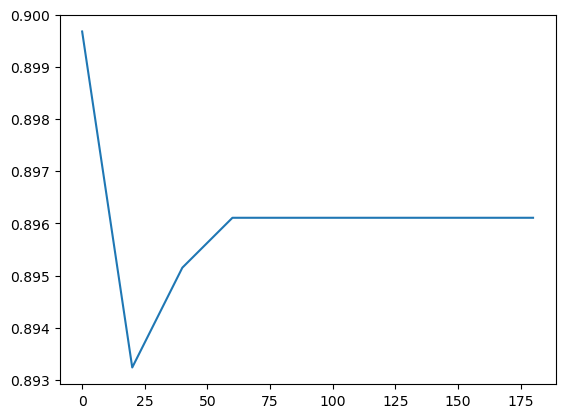

In [75]:
plt.plot(liste_nb_sw, perf_nb_sw)

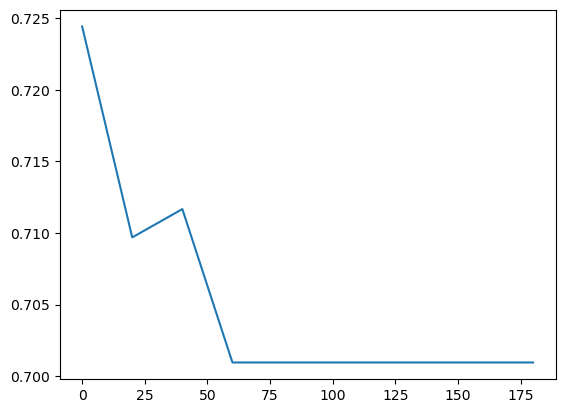

In [76]:
plt.plot(liste_nb_sw, perf_lr_sw)

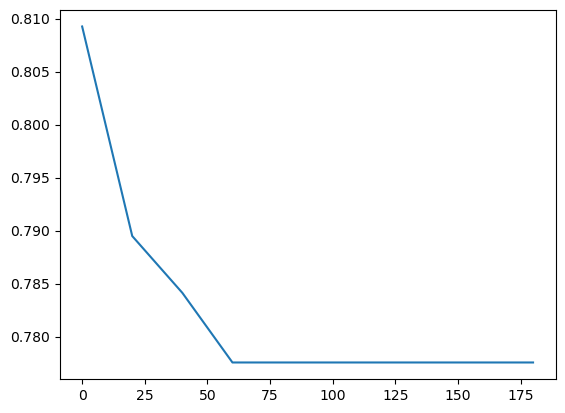

In [77]:
plt.plot(liste_nb_sw, perf_svm_sw)

A priori enlever les stopwords n'améliore pas la performance, donc on ne le fait pas.

In [78]:
results_fit = results_fit.drop('stopwords')
results_cv = results_cv.drop('stopwords')

In [79]:
# loop sur max_features pour voir où sont les meilleures perf
liste_nb_feat = []
temps_fit_nb = []
temps_fit_lr = []
temps_fit_svm = []
perf_nb_feat = []
perf_lr_feat = []
perf_svm_feat = []

for feat in range(100,50000,1000):
    liste_nb_feat.append(feat)

    vectorizer = CountVectorizer(strip_accents='ascii', preprocessor=preprocess, 
                            ngram_range=(1,3), max_features=feat)

    X_train = vectorizer.fit_transform(corpus_fit) 
    X_test = vectorizer.transform(corpus_boost)

    #Naïve Bayes
    start_nb = time.time()
    nb_clf = MultinomialNB()
    nb_clf.fit(X_train, classes_fit)
    perf_nb_feat.append(nb_clf.score(X_test, classes_boost))
    end_nb = time.time()
    temps_fit_nb.append(end_nb - start_nb)

    #Logistic Regression
    start_lr = time.time()
    lr_clf = LogisticRegression(random_state=0, C=1e-3)
    lr_clf.fit(X_train, classes_fit)
    perf_lr_feat.append(lr_clf.score(X_test, classes_boost))
    end_lr = time.time()
    temps_fit_lr.append(end_lr - start_lr)

    #Linear SVM
    start_svm = time.time()
    svm_clf = LinearSVC(random_state=0, tol=1e-5, C=1e-3)
    svm_clf.fit(X_train, classes_fit)
    perf_svm_feat.append(svm_clf.score(X_test, classes_boost))
    end_svm = time.time()
    temps_fit_svm.append(end_svm - start_svm)

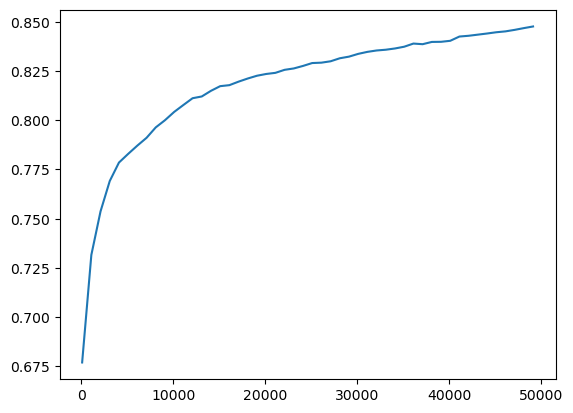

In [80]:
plt.plot(liste_nb_feat, perf_nb_feat)

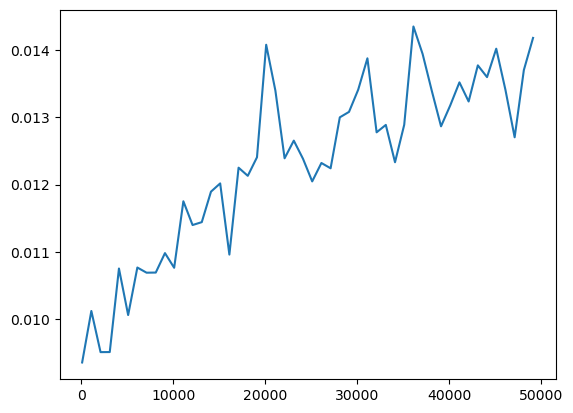

In [81]:
plt.plot(liste_nb_feat, temps_fit_nb)

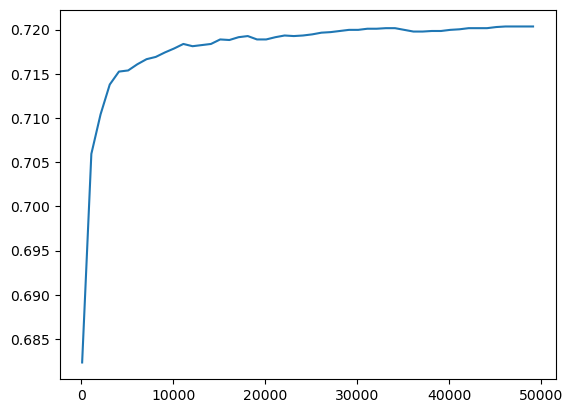

In [82]:
plt.plot(liste_nb_feat, perf_lr_feat)

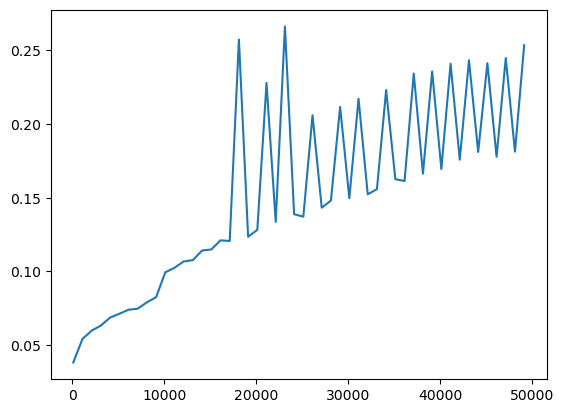

In [83]:
plt.plot(liste_nb_feat, temps_fit_lr)

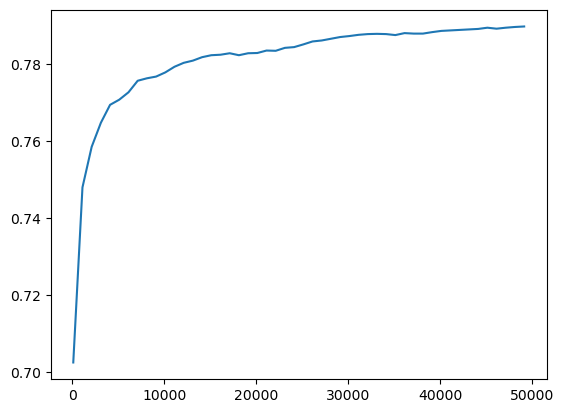

In [84]:
plt.plot(liste_nb_feat, perf_svm_feat)

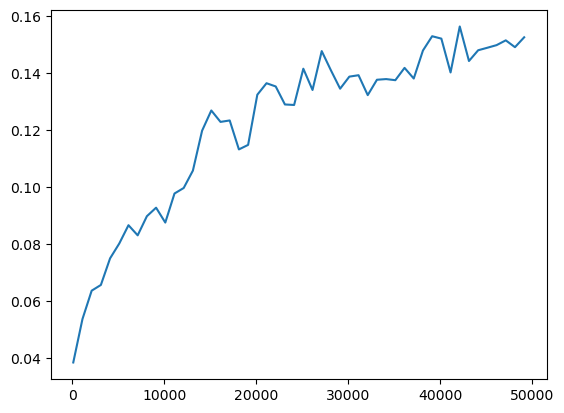

In [85]:
plt.plot(liste_nb_feat, temps_fit_svm)

In [86]:
#Naïve Bayes

vectorizer_feat_nb = CountVectorizer(strip_accents='ascii', preprocessor=preprocess, 
                                ngram_range=(1,3), max_features=liste_nb_feat[np.argmax(perf_nb_feat)])

X_train_feat_nb = vectorizer_feat_nb.fit_transform(corpus_fit) 
X_test_feat_nb = vectorizer_feat_nb.transform(corpus_boost)

start_nb = time.time()
nb_clf = MultinomialNB()
nb_clf.fit(X_train_feat_nb, classes_fit)
end_nb = time.time()
results_fit.loc['max_features', 'NB'] = nb_clf.score(X_test_feat_nb, classes_boost)
results_fit.loc['max_features', 'Temps_NB'] = end_nb - start_nb

X_feat_nb = vectorizer_feat_nb.fit_transform(X_new_train)
start_nb = time.time()
cv_feat_nb = cross_val_score(nb_clf, X_feat_nb, y_new_train, cv=5, scoring='accuracy')
end_nb = time.time()
results_cv.loc['max_features', 'NB'] = cv_feat_nb.mean()
results_cv.loc['max_features', 'Temps_NB'] = end_nb - start_nb

#Logistic Regression

vectorizer_feat_lr = CountVectorizer(strip_accents='ascii', preprocessor=preprocess, 
                                ngram_range=(1,3), max_features=liste_nb_feat[np.argmax(perf_lr_feat)])

X_train_feat_lr = vectorizer_feat_lr.fit_transform(corpus_fit) 
X_test_feat_lr = vectorizer_feat_lr.transform(corpus_boost)

start_lr = time.time()
lr_clf = LogisticRegression(random_state=0, C=1e-3)
lr_clf.fit(X_train_feat_lr, classes_fit)
end_lr = time.time()
results_fit.loc['max_features', 'LR'] = lr_clf.score(X_test_feat_lr, classes_boost)
results_fit.loc['max_features', 'Temps_LR'] = end_lr - start_lr

X_feat_lr = vectorizer_feat_lr.fit_transform(X_new_train)
start_lr = time.time()
cv_feat_lr = cross_val_score(lr_clf, X_feat_lr, y_new_train, cv=5, scoring='accuracy')
end_lr = time.time()
results_cv.loc['max_features', 'LR'] = cv_feat_lr.mean()
results_cv.loc['max_features', 'Temps_LR'] = end_nb - start_nb

#Linear SVM

vectorizer_feat_svm = CountVectorizer(strip_accents='ascii', preprocessor=preprocess, 
                                ngram_range=(1,3), max_features=liste_nb_feat[np.argmax(perf_svm_feat)])

X_train_feat_svm = vectorizer_feat_svm.fit_transform(corpus_fit) 
X_test_feat_svm = vectorizer_feat_svm.transform(corpus_boost)

start_svm = time.time()
svm_clf = LinearSVC(random_state=0, tol=1e-5, C=1e-3)
svm_clf.fit(X_train_feat_svm, classes_fit)
end_svm = time.time()
results_fit.loc['max_features', 'SVM'] = svm_clf.score(X_test_feat_svm, classes_boost)
results_fit.loc['max_features', 'Temps_SVM'] = end_svm - start_svm

X_feat_svm = vectorizer_feat_svm.fit_transform(X_new_train)
start_svm = time.time()
cv_feat_svm = cross_val_score(svm_clf, X_feat_svm, y_new_train, cv=5, scoring='accuracy')
end_svm = time.time()
results_cv.loc['max_features', 'SVM'] = cv_feat_svm.mean()
results_cv.loc['max_features', 'Temps_SVM'] = end_svm - start_svm

In [87]:
results_fit

,NB,Temps_NB,LR,Temps_LR,SVM,Temps_SVM
ø,0.830421,0.008595,0.706122,0.103404,0.762628,0.068686
lower+punc,0.830421,0.005805,0.706122,0.147398,0.762628,0.067028
"ngram=(1,1)",0.830421,0.005535,0.706122,0.147088,0.762628,0.068464
"ngram=(1,2)",0.887309,0.012655,0.71977,0.52405,0.793686,0.199495
"ngram=(1,3)",0.899681,0.020157,0.724426,1.261636,0.809247,0.376856
strip_accents,0.899681,0.020942,0.724426,1.358579,0.809247,0.356337
max_features,0.847577,0.007019,0.720344,0.289688,0.789668,0.280654
max_def,NaN,NaN,NaN,NaN,NaN,NaN
boost,NaN,NaN,NaN,NaN,NaN,NaN


In [88]:
results_cv

,NB,Temps_NB,LR,Temps_LR,SVM,Temps_SVM
ø,0.839352,0.076032,0.710527,0.734892,0.767837,0.534928
lower+punc,0.839352,0.067375,0.710527,0.696973,0.767837,0.553665
"ngram=(1,1)",0.839352,0.065632,0.710527,0.674601,0.767837,0.523669
"ngram=(1,2)",0.909858,0.114985,0.725281,3.507537,0.805931,1.524249
"ngram=(1,3)",0.929094,0.231147,0.732268,8.34776,0.829713,2.583102
strip_accents,0.929094,0.20774,0.732268,8.164613,0.829713,2.485488
max_features,0.862062,0.088231,0.726333,0.088231,0.802711,1.194292
max_def,NaN,NaN,NaN,NaN,NaN,NaN
boost,NaN,NaN,NaN,NaN,NaN,NaN


Diminuer le nombre de features ne semble pas améliorer le score, on ne va donc pas le faire.

In [89]:
results_fit = results_fit.drop('max_features')
results_cv = results_cv.drop('max_features')

In [90]:
# loop sur max_df pour voir où sont les meilleures perf
liste_max_df = []
perf_nb_df = []
perf_lr_df = []
perf_svm_df = []

for df in range(100,10000,100):
    liste_max_df.append(df)

    vectorizer_nb = CountVectorizer(strip_accents='ascii', preprocessor=preprocess, 
                                ngram_range=(1,3), min_df=1, max_df=df)
    vectorizer_lr = CountVectorizer(strip_accents='ascii', preprocessor=preprocess, 
                                ngram_range=(1,3), min_df=1, max_df=df)
    vectorizer_svm = CountVectorizer(strip_accents='ascii', preprocessor=preprocess, 
                                ngram_range=(1,3), min_df=1, max_df=df)


    X_train_nb = vectorizer_nb.fit_transform(corpus_fit) 
    X_test_nb = vectorizer_nb.transform(corpus_boost)

    X_train_lr = vectorizer_lr.fit_transform(corpus_fit) 
    X_test_lr = vectorizer_lr.transform(corpus_boost)

    X_train_svm = vectorizer_svm.fit_transform(corpus_fit) 
    X_test_svm = vectorizer_svm.transform(corpus_boost)

    #Naïve Bayes
    nb_clf = MultinomialNB()
    nb_clf.fit(X_train_nb, classes_fit)

    #Logistic Regression
    lr_clf = LogisticRegression(random_state=0, C=1e-3)
    lr_clf.fit(X_train_lr, classes_fit)

    #Linear SVM
    svm_clf = LinearSVC(random_state=0, tol=1e-5, C=1e-3)
    svm_clf.fit(X_train_svm, classes_fit)

    perf_nb_df.append(nb_clf.score(X_test_nb, classes_boost))
    perf_lr_df.append(lr_clf.score(X_test_lr, classes_boost))
    perf_svm_df.append(svm_clf.score(X_test_svm, classes_boost))

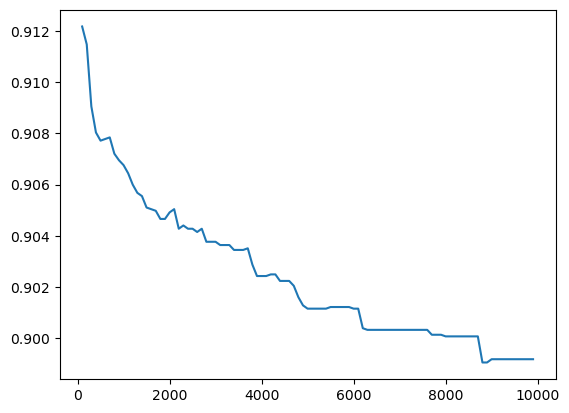

In [91]:
plt.plot(liste_max_df, perf_nb_df)

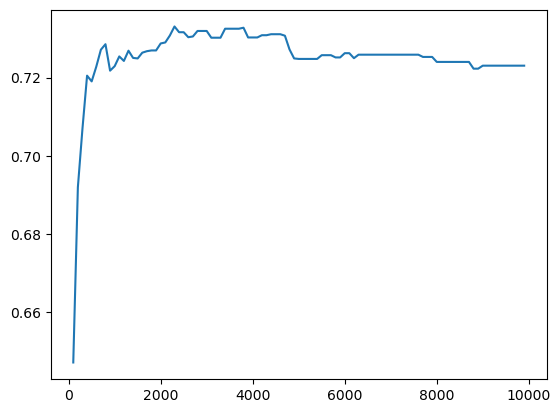

In [92]:
plt.plot(liste_max_df, perf_lr_df)

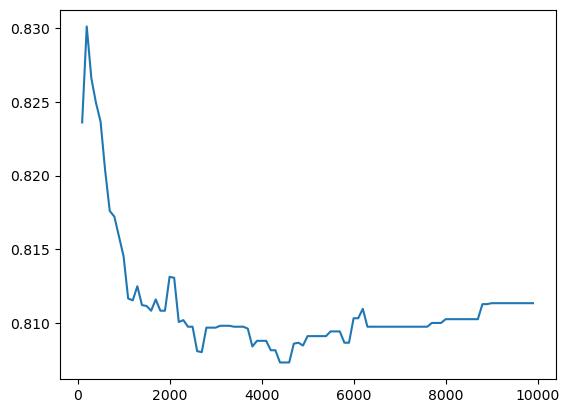

In [93]:
plt.plot(liste_max_df, perf_svm_df)

In [94]:
#Naïve Bayes

vectorizer_df_nb = CountVectorizer(strip_accents='ascii', preprocessor=preprocess, 
                                ngram_range=(1,3), min_df=1, max_df=liste_max_df[np.argmax(perf_nb_df)])

X_train_df_nb = vectorizer_df_nb.fit_transform(corpus_fit) 
X_test_df_nb = vectorizer_df_nb.transform(corpus_boost)

start_nb = time.time()
nb_clf = MultinomialNB()
nb_clf.fit(X_train_df_nb, classes_fit)
end_nb = time.time()
results_fit.loc['max_def', 'NB'] = nb_clf.score(X_test_df_nb, classes_boost)
results_fit.loc['max_def', 'Temps_NB'] = end_nb - start_nb

X_df_nb = vectorizer_feat_nb.fit_transform(X_new_train)
start_nb = time.time()
cv_df_nb = cross_val_score(nb_clf, X_df_nb, y_new_train, cv=5, scoring='accuracy')
end_nb = time.time()
results_cv.loc['max_def', 'NB'] = cv_df_nb.mean()
results_cv.loc['max_def', 'Temps_NB'] = end_nb - start_nb

#Logistic Regression

vectorizer_df_lr = CountVectorizer(strip_accents='ascii', preprocessor=preprocess, 
                                ngram_range=(1,3), min_df=1, max_df=liste_max_df[np.argmax(perf_lr_df)])

X_train_df_lr = vectorizer_df_lr.fit_transform(corpus_fit) 
X_test_df_lr = vectorizer_df_lr.transform(corpus_boost)

start_lr = time.time()
lr_clf = LogisticRegression(random_state=0, C=1e-3)
lr_clf.fit(X_train_df_lr, classes_fit)
end_lr = time.time()
results_fit.loc['max_def', 'LR'] = lr_clf.score(X_test_df_lr, classes_boost)
results_fit.loc['max_def', 'Temps_LR'] = end_lr - start_lr

X_df_lr = vectorizer_feat_lr.fit_transform(X_new_train)
start_lr = time.time()
cv_df_lr = cross_val_score(lr_clf, X_df_lr, y_new_train, cv=5, scoring='accuracy')
end_lr = time.time()
results_cv.loc['max_def', 'LR'] = cv_df_lr.mean()
results_cv.loc['max_def', 'Temps_LR'] = end_nb - start_nb

#Linear SVM

vectorizer_df_svm = CountVectorizer(strip_accents='ascii', preprocessor=preprocess, 
                                ngram_range=(1,3), min_df=1, max_df=liste_max_df[np.argmax(perf_svm_df)])

X_train_df_svm = vectorizer_feat_svm.fit_transform(corpus_fit) 
X_test_df_svm = vectorizer_feat_svm.transform(corpus_boost)

start_svm = time.time()
svm_clf = LinearSVC(random_state=0, tol=1e-5, C=1e-3)
svm_clf.fit(X_train_df_svm, classes_fit)
end_svm = time.time()
results_fit.loc['max_def', 'SVM'] = svm_clf.score(X_test_df_svm, classes_boost)
results_fit.loc['max_def', 'Temps_SVM'] = end_svm - start_svm

X_df_svm = vectorizer_df_svm.fit_transform(X_new_train)
start_svm = time.time()
cv_df_svm = cross_val_score(svm_clf, X_df_svm, y_new_train, cv=5, scoring='accuracy')
end_svm = time.time()
results_cv.loc['max_def', 'SVM'] = cv_df_svm.mean()
results_cv.loc['max_def', 'Temps_SVM'] = end_svm - start_svm

In [95]:
results_cv

,NB,Temps_NB,LR,Temps_LR,SVM,Temps_SVM
ø,0.839352,0.076032,0.710527,0.734892,0.767837,0.534928
lower+punc,0.839352,0.067375,0.710527,0.696973,0.767837,0.553665
"ngram=(1,1)",0.839352,0.065632,0.710527,0.674601,0.767837,0.523669
"ngram=(1,2)",0.909858,0.114985,0.725281,3.507537,0.805931,1.524249
"ngram=(1,3)",0.929094,0.231147,0.732268,8.34776,0.829713,2.583102
strip_accents,0.929094,0.20774,0.732268,8.164613,0.829713,2.485488
max_def,0.862062,0.089655,0.726333,0.089655,0.862272,1.222378
boost,NaN,NaN,NaN,NaN,NaN,NaN


In [96]:
results_fit

,NB,Temps_NB,LR,Temps_LR,SVM,Temps_SVM
ø,0.830421,0.008595,0.706122,0.103404,0.762628,0.068686
lower+punc,0.830421,0.005805,0.706122,0.147398,0.762628,0.067028
"ngram=(1,1)",0.830421,0.005535,0.706122,0.147088,0.762628,0.068464
"ngram=(1,2)",0.887309,0.012655,0.71977,0.52405,0.793686,0.199495
"ngram=(1,3)",0.899681,0.020157,0.724426,1.261636,0.809247,0.376856
strip_accents,0.899681,0.020942,0.724426,1.358579,0.809247,0.356337
max_def,0.912181,0.027155,0.733036,1.411529,0.789668,0.183844
boost,NaN,NaN,NaN,NaN,NaN,NaN


## Première campagne d'expériences

Les techniques sur lesquelles nous travaillons étant sujettes au sur-apprentissage: trouver le paramètre de régularisation dans la documentation et optimiser ce paramètre au sens de la métrique qui vous semble la plus appropriée (cf question précédente).

- Pour la régression logistique et le SVM linéaire, le paramètre de régularisation est C.
- Pour la Multinomial NB, c'est $\alpha$.

On peut jouer sur ces paramètres avec un GridSearch.

In [135]:
vectorizer_nb = CountVectorizer(strip_accents='ascii', preprocessor=preprocess, 
                                ngram_range=(1,3), min_df=1, max_df=liste_max_df[np.argmax(perf_nb_df)])

from sklearn.model_selection import GridSearchCV

X_boost_nb = vectorizer_nb.fit_transform(corpus_boost)
params_nb = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1]}

GS_nb = GridSearchCV(nb_clf, param_grid=params_nb, scoring='accuracy', n_jobs=3)
GS_nb.fit(X_boost_nb, classes_boost)

boost_NB = GS_nb.best_estimator_

In [136]:
X_train_nb = vectorizer_nb.fit_transform(corpus_fit)
X_test_nb = vectorizer_nb.transform(corpus_boost)

start_nb = time.time()
boost_NB.fit(X_train_nb, classes_fit)
end_nb = time.time()

results_fit.loc['boost','NB'] = boost_NB.score(X_test_nb, classes_boost)
results_fit.loc['boost','Temps_NB'] = end_nb-start_nb

In [137]:
X = vectorizer_nb.fit_transform(text_train)

start_nb = time.time()
cv_nb = cross_val_score(boost_NB, X, y_train, cv=5, scoring='accuracy')
end_nb = time.time()

results_cv.loc['boost','NB'] = cv_nb.mean()
results_cv.loc['boost','Temps_NB'] = end_nb-start_nb

In [138]:
vectorizer_lr = CountVectorizer(strip_accents='ascii', preprocessor=preprocess, 
                                ngram_range=(1,3), min_df=1, max_df=liste_max_df[np.argmax(perf_lr_df)])

X_boost_lr = vectorizer_lr.fit_transform(corpus_boost)
params_lr = {'tol':[1e-6, 1e-5, 1e-4, 1e-3], 'C' : [1e-6, 1e-5, 1e-4, 1e-3]}

GS_lr = GridSearchCV(lr_clf, param_grid=params_lr, scoring='accuracy', n_jobs=3)
GS_lr.fit(X_boost_lr, classes_boost)
boost_LR = GS_lr.best_estimator_

In [139]:
X_train_lr = vectorizer_nb.fit_transform(corpus_fit)
X_test_lr = vectorizer_nb.transform(corpus_boost)

start_lr = time.time()
boost_LR.fit(X_train_lr, classes_fit)
end_lr = time.time()

results_fit.loc['boost','LR'] = boost_LR.score(X_test_lr, classes_boost)
results_fit.loc['boost','Temps_LR'] = end_lr-start_lr

In [140]:
X = vectorizer_nb.fit_transform(text_train)

start_lr = time.time()
cv_lr = cross_val_score(boost_LR, X, y_train, cv=5, scoring='accuracy')
end_lr = time.time()

results_cv.loc['boost','LR'] = cv_lr.mean()
results_cv.loc['boost','Temps_LR'] = end_lr-start_lr

In [141]:
vectorizer_svm = CountVectorizer(strip_accents='ascii', preprocessor=preprocess, 
                                ngram_range=(1,3), min_df=1, max_df=liste_max_df[np.argmax(perf_svm_df)])

X_boost_svm = vectorizer_svm.fit_transform(corpus_boost)
params_svm = {'tol':[1e-6, 1e-5, 1e-4, 1e-3], 'C' : [1e-6, 1e-5, 1e-4, 1e-3]}

svm_clf = LinearSVC(random_state=0)

GS_svm = GridSearchCV(svm_clf, param_grid=params_svm, scoring='accuracy', n_jobs=3)
GS_svm.fit(X_boost_svm, classes_boost)
boost_SVM = GS_svm.best_estimator_

In [142]:
X_train_svm = vectorizer_svm.fit_transform(corpus_fit)
X_test_svm = vectorizer_svm.transform(corpus_boost)

start_svm = time.time()
boost_SVM.fit(X_train_svm, classes_fit)
end_svm = time.time()

results_fit.loc['boost','SVM'] = boost_SVM.score(X_test_svm, classes_boost)
results_fit.loc['boost','Temps_SVM'] = end_svm-start_svm

In [143]:
X = vectorizer_svm.fit_transform(text_train)

start_svm = time.time()
cv_svm = cross_val_score(boost_SVM, X, y_train, cv=5, scoring='accuracy')
end_svm = time.time()

results_cv.loc['boost','SVM'] = cv_svm.mean()
results_cv.loc['boost','Temps_SVM'] = end_svm-start_svm

In [144]:
results_fit

,NB,Temps_NB,LR,Temps_LR,SVM,Temps_SVM
ø,0.830421,0.008595,0.706122,0.103404,0.762628,0.068686
lower+punc,0.830421,0.005805,0.706122,0.147398,0.762628,0.067028
"ngram=(1,1)",0.830421,0.005535,0.706122,0.147088,0.762628,0.068464
"ngram=(1,2)",0.887309,0.012655,0.71977,0.52405,0.793686,0.199495
"ngram=(1,3)",0.899681,0.020157,0.724426,1.261636,0.809247,0.376856
strip_accents,0.899681,0.020942,0.724426,1.358579,0.809247,0.356337
max_def,0.912181,0.027155,0.733036,1.411529,0.789668,0.183844
boost,0.912181,0.026338,0.647194,0.968928,0.830102,0.287655


In [149]:
results_cv

,NB,Temps_NB,LR,Temps_LR,SVM,Temps_SVM
ø,0.839352,0.076032,0.710527,0.734892,0.767837,0.534928
lower+punc,0.839352,0.067375,0.710527,0.696973,0.767837,0.553665
"ngram=(1,1)",0.839352,0.065632,0.710527,0.674601,0.767837,0.523669
"ngram=(1,2)",0.909858,0.114985,0.725281,3.507537,0.805931,1.524249
"ngram=(1,3)",0.929094,0.231147,0.732268,8.34776,0.829713,2.583102
strip_accents,0.929094,0.20774,0.732268,8.164613,0.829713,2.485488
max_def,0.862062,0.089655,0.726333,0.089655,0.862272,1.222378
boost,0.825057,0.267734,0.868967,11.667836,0.871684,1.621889


## Test du modèle boosté sur les données test

In [145]:
vectorizer_nb.fit(corpus_fit)
X_train_nb = vectorizer_nb.fit_transform(corpus_fit)
X_test_nb = vectorizer_nb.transform(text_test)

#Naïve Bayes
nb_clf = boost_NB
nb_clf.fit(X_train_nb, classes_fit)

print(nb_clf.score(X_test_nb, classes_test))
pred_nb = nb_clf.predict(X_test_nb)

0.7088211471909285


In [146]:
vectorizer_lr = vectorizer_df_lr

vectorizer_lr.fit(corpus_fit, classes_fit)
X_train_lr = vectorizer_lr.fit_transform(corpus_fit)
X_test_lr = vectorizer_lr.transform(text_test)

#Logistic Regression
lr_clf = boost_LR
lr_clf.fit(X_train_lr, classes_fit)

print(lr_clf.score(X_test_lr, classes_test))
pred_lr = lr_clf.predict(X_test_lr)

0.7756792577866136


In [147]:
vectorizer_svm.fit(corpus_fit)
X_train_svm = vectorizer_svm.fit_transform(corpus_fit)
X_test_svm = vectorizer_svm.transform(text_test)

#SVM
svm_clf = boost_SVM
svm_clf.fit(X_train_svm, classes_fit)

print(svm_clf.score(X_test_svm, classes_test))
pred_svm = svm_clf.predict(X_test_svm)

0.8044694794197776


In [148]:
print(sum(pred_nb==1)/len(pred_nb))
print(sum(pred_nb!=1)/len(pred_nb))

print(sum(pred_lr==1)/len(pred_lr))
print(sum(pred_lr!=1)/len(pred_lr))

print(sum(pred_svm==1)/len(pred_svm))
print(sum(pred_svm!=1)/len(pred_svm))

0.7714822178042854
0.2285177821957146
0.8473234666077608
0.15267653339223916
0.8851704587291068
0.11482954127089316


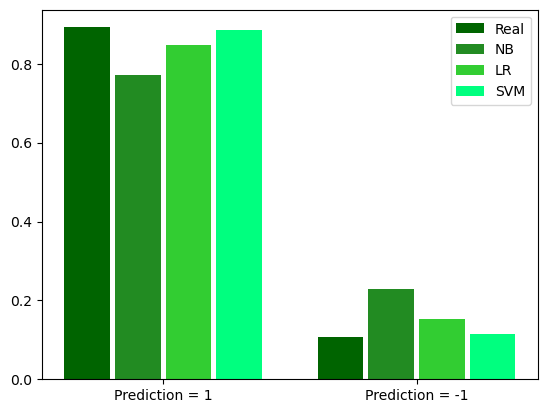

In [167]:
barwidth = 0.9

plt.bar(x=[1], width=barwidth, height=sum(np.array(y_test)==1)/len(y_test), color='darkgreen', label='Real')
plt.bar(x=[2], width=barwidth, height=sum(pred_nb==1)/len(pred_nb), color='forestgreen', label='NB')
plt.bar(x=[3], width=barwidth, height=sum(pred_lr==1)/len(pred_nb), color='limegreen', label='LR')
plt.bar(x=[4], width=barwidth, height=sum(pred_svm==1)/len(pred_nb), color='springgreen', label='SVM')

plt.bar(x=[6], width=barwidth, height=sum(np.array(y_test)!=1)/len(y_test), color='darkgreen')
plt.bar(x=[7], width=barwidth, height=sum(pred_nb!=1)/len(pred_nb), color='forestgreen')
plt.bar(x=[8], width=barwidth, height=sum(pred_lr!=1)/len(pred_nb), color='limegreen')
plt.bar(x=[9], width=barwidth, height=sum(pred_svm!=1)/len(pred_nb), color='springgreen')

plt.xticks([r for r in [2.5, 7.5]], ['Prediction = 1', 'Prediction = -1'])

plt.legend()

Text(0.5, 1.0, 'Evolution de la performance (accuracy) avec le prétraitement selon les modèles')

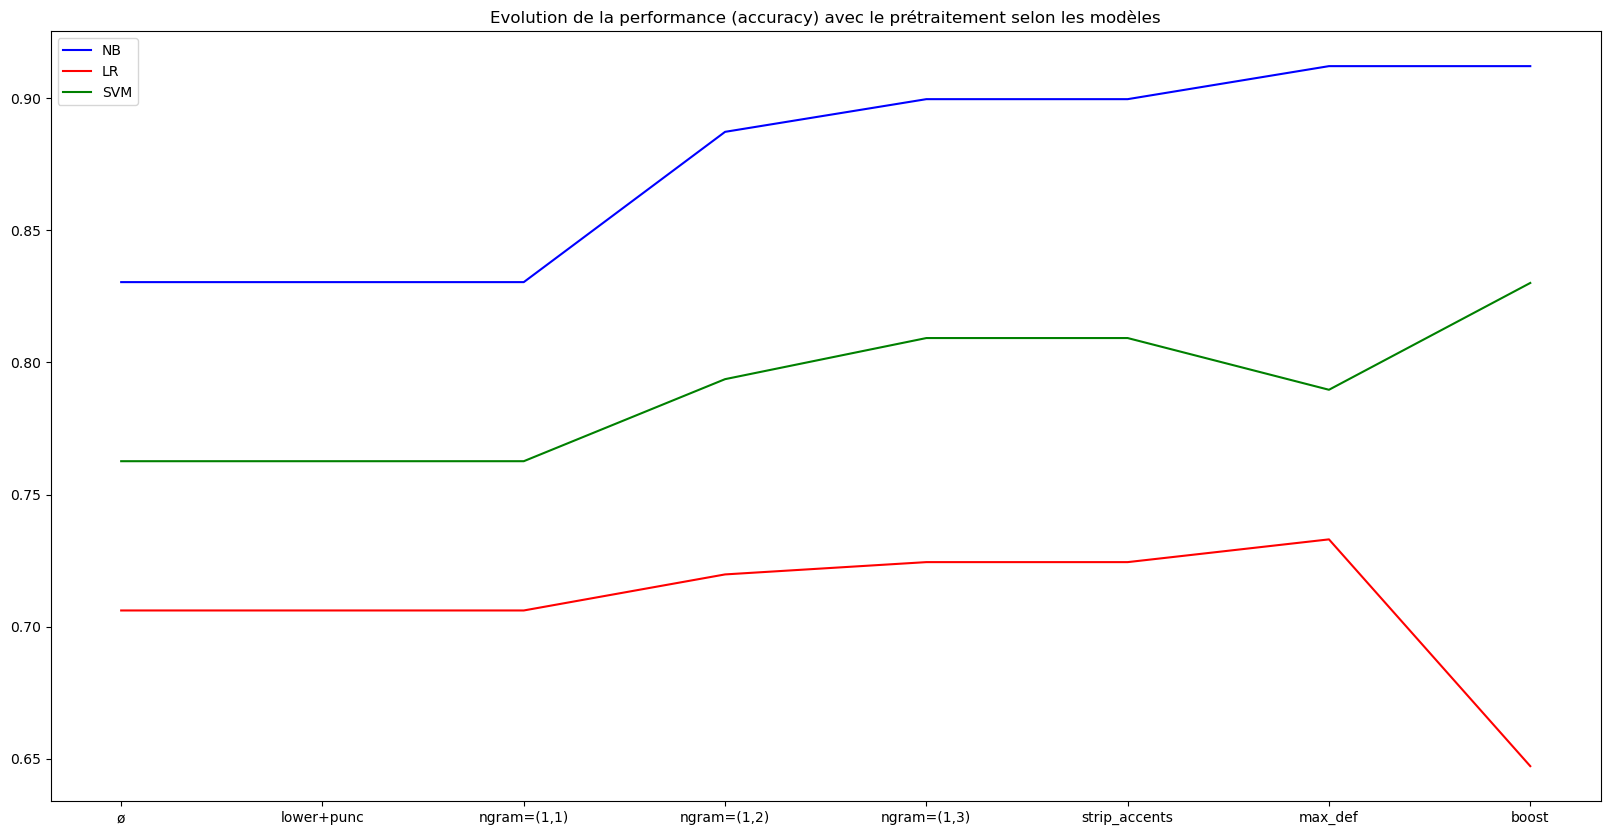

In [111]:
plt.figure(figsize=(20,10))
plt.plot(results_fit['NB'], 'b')
plt.plot(results_fit['LR'], 'r')
plt.plot(results_fit['SVM'], 'g')
plt.legend(['NB', 'LR', 'SVM'])
plt.title('Evolution de la performance (accuracy) avec le prétraitement selon les modèles')

Text(0.5, 1.0, 'Evolution de la performance (accuracy) avec le prétraitement selon les modèles + cross-validation')

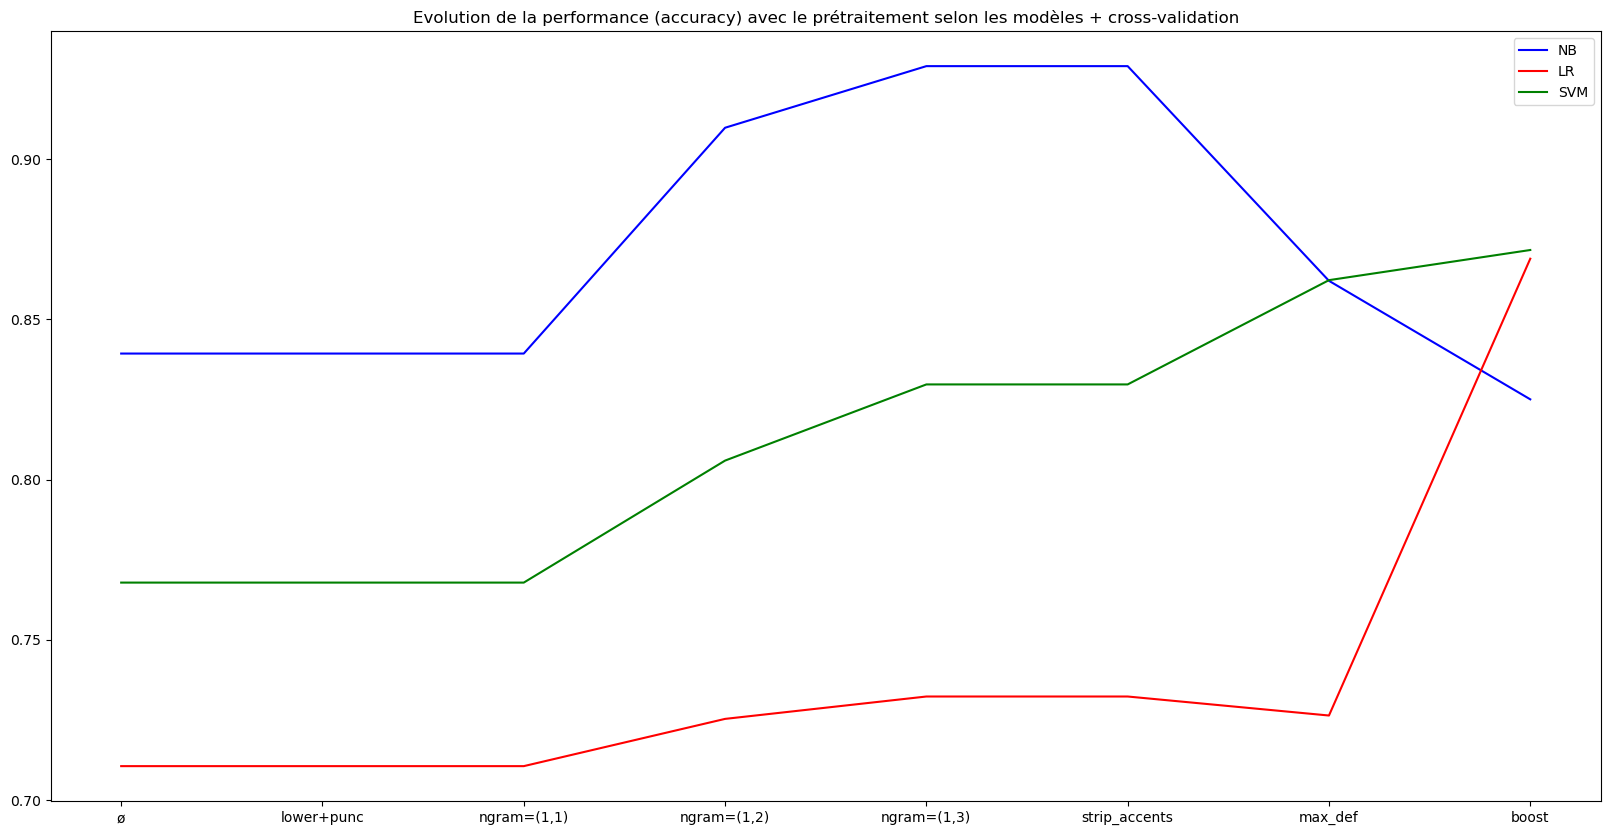

In [112]:
plt.figure(figsize=(20,10))
plt.plot(results_cv['NB'], 'b')
plt.plot(results_cv['LR'], 'r')
plt.plot(results_cv['SVM'], 'g')
plt.legend(['NB', 'LR', 'SVM'])
plt.title('Evolution de la performance (accuracy) avec le prétraitement selon les modèles + cross-validation')

Post-traitement

Les phrases sont groupées, on veut essayer de voir par combien environ.

In [113]:
pred_lr = list(pred_lr)
pred_nb = list(pred_nb)
pred_svm = list(pred_svm)

In [114]:
def count(list):
    cpt = 0
    cpt_list = []
    for k in range(len(list)-1):
        if list[k] == list[k+1]:
            cpt+=1
        else:
            cpt+=1
            cpt_list.append(cpt)
            cpt=0
    if list[-2] == list[-1]:
        cpt+=1
        cpt_list.append(cpt)
    else:
        cpt_list.append(1)
    return(cpt_list)

In [115]:
print(np.mean(count(y_test)))

5.455312311709179


On prend un pas de 5.

In [116]:
pred_lr_bis = pred_lr.copy()
pred_nb_bis = pred_nb.copy()
pred_svm_bis = pred_svm.copy()

In [117]:
def post_processing(list, list_bis, fenetre): 
    for i in range(len(list)-fenetre):
        if sum(pred_lr[i:i+fenetre])<0:
            list_bis[i:i+fenetre] = [-1 for j in list_bis[i:i+fenetre]]
        else:
            list_bis[i:i+fenetre] = [1 for j in list_bis[i:i+fenetre]]
    return list_bis

In [118]:
real_score_1 = y_test.count(1)/len(y_test)

In [119]:
scores_pp_nb = []
scores_pp_lr = []
scores_pp_svm = []
taille_fenetre = []

for f in range(2,40):
    taille_fenetre.append(f)
    pp_nb = post_processing(pred_nb, pred_nb_bis, f)
    pp_lr = post_processing(pred_lr, pred_lr_bis, f)
    pp_svm = post_processing(pred_svm, pred_svm_bis, f)

    scores_pp_nb.append(np.abs((pp_nb.count(1)/len(pp_nb))-real_score_1))
    scores_pp_lr.append(np.abs((pp_lr.count(1)/len(pp_lr))-real_score_1))
    scores_pp_svm.append(np.abs((pp_svm.count(1)/len(pp_svm))-real_score_1))

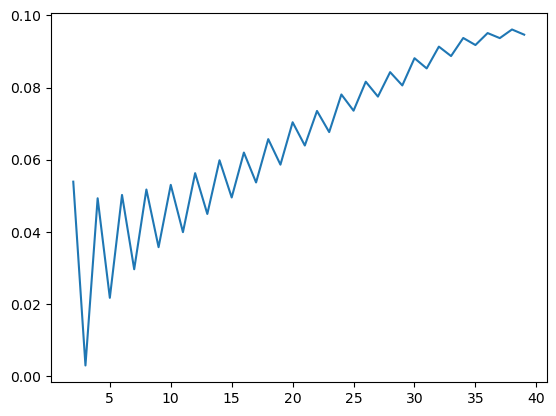

In [120]:
plt.plot(taille_fenetre, scores_pp_nb)

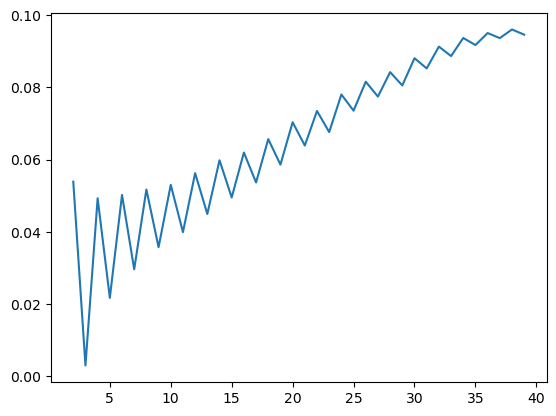

In [121]:
plt.plot(taille_fenetre,scores_pp_lr)

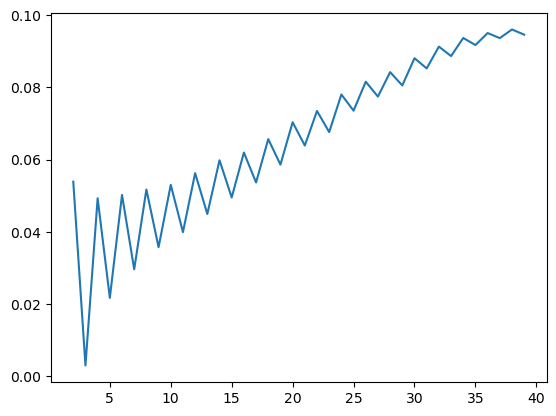

In [122]:
plt.plot(taille_fenetre, scores_pp_svm)

In [123]:
f_nb = taille_fenetre[np.argmin(scores_pp_nb)]
f_lr = taille_fenetre[np.argmin(scores_pp_lr)]
f_svm = taille_fenetre[np.argmin(scores_pp_svm)]

In [124]:
pred_finale_nb = post_processing(pred_nb, pred_nb.copy(), f_nb)
pred_finale_lr = post_processing(pred_lr, pred_lr.copy(), f_lr)
pred_finale_svm = post_processing(pred_svm, pred_svm.copy(), f_svm)

In [202]:
pred_finale_nb.count(1)/len(pred_nb)

0.8955894264045358

In [211]:
resultats = pd.DataFrame({'predictions': [y_test.count(1)/len(y_test), sum(pred_nb==1)/len(pred_nb), sum(pred_lr==1)/len(pred_lr), sum(pred_svm==1)/len(pred_svm)], 
                          'predictions_corr': [y_test.count(1)/len(y_test), pred_finale_nb.count(1)/len(pred_finale_nb), pred_finale_lr.count(1)/len(pred_finale_lr), pred_finale_svm.count(1)/len(pred_finale_svm)],
                          'predictions_types': ['Real 1', 'Multinomial NB 1', 'Logistic Regression 1', 'SVM 1']})

resultats_bis = pd.DataFrame({'predictions': [y_test.count(-1)/len(y_test), sum(pred_nb==(-1))/len(pred_nb), sum(pred_lr==(-1))/len(pred_lr), sum(pred_svm==(-1))/len(pred_svm)], 
                          'predictions_corr': [y_test.count(-1)/len(y_test), pred_finale_nb.count(-1)/len(pred_finale_nb), pred_finale_lr.count(-1)/len(pred_finale_lr), pred_finale_svm.count(-1)/len(pred_finale_svm)],
                          'predictions_types': ['Real -1', 'Multinomial NB -1', 'Logistic Regression -1', 'SVM -1']})

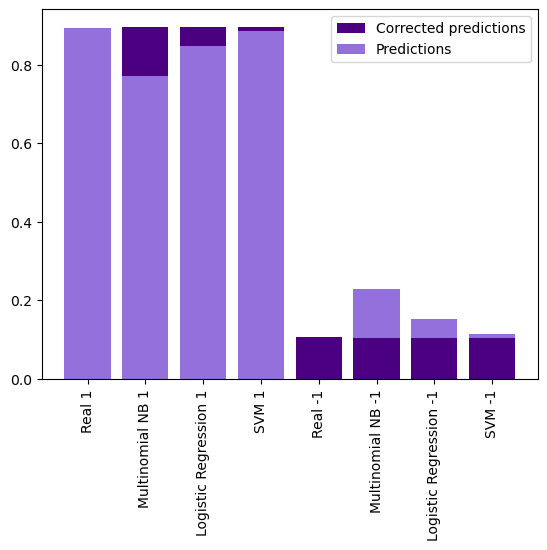

In [236]:
plt.bar(x=resultats['predictions_types'], height=resultats['predictions_corr'], color='indigo', label='Corrected predictions')
plt.bar(x=resultats['predictions_types'], height=resultats['predictions'], color='mediumpurple', label='Predictions')

plt.bar(x=resultats_bis['predictions_types'], height=resultats_bis['predictions'], color='mediumpurple')
plt.bar(x=resultats_bis['predictions_types'], height=resultats_bis['predictions_corr'], color='indigo')

plt.xticks(rotation=90)

plt.legend(loc='upper right')

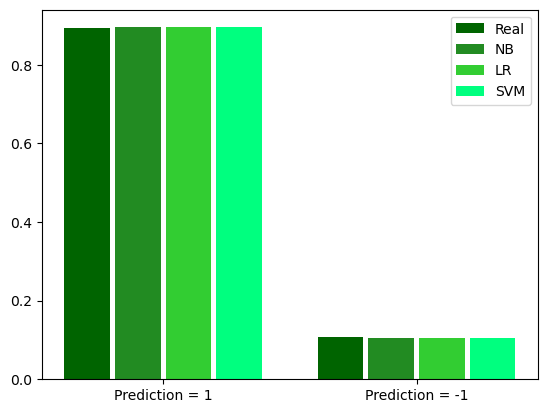

In [170]:
barwidth = 0.9

plt.bar(x=[1], width=barwidth, height=sum(np.array(y_test)==1)/len(y_test), color='darkgreen', label='Real')
plt.bar(x=[2], width=barwidth, height=pred_finale_nb.count(1)/len(pred_finale_nb), color='forestgreen', label='NB')
plt.bar(x=[3], width=barwidth, height=pred_finale_lr.count(1)/len(pred_finale_nb), color='limegreen', label='LR')
plt.bar(x=[4], width=barwidth, height=pred_finale_svm.count(1)/len(pred_finale_nb), color='springgreen', label='SVM')

plt.bar(x=[6], width=barwidth, height=sum(np.array(y_test)!=1)/len(y_test), color='darkgreen')
plt.bar(x=[7], width=barwidth, height=pred_finale_nb.count(-1)/len(pred_finale_nb), color='forestgreen')
plt.bar(x=[8], width=barwidth, height=pred_finale_lr.count(-1)/len(pred_finale_nb), color='limegreen')
plt.bar(x=[9], width=barwidth, height=pred_finale_svm.count(-1)/len(pred_finale_nb), color='springgreen')

plt.xticks([r for r in [2.5, 7.5]], ['Prediction = 1', 'Prediction = -1'])

plt.legend()